---
# Objetivo: Treinar 3 modelos e Ensemble para observar se a performance melhora.
---


**1- Descrição do problema ou tarefa:**

Prever a categorias frutas, animais e graos a partir das perguntas.

**2- Descrição da solução de IA:**
Treinamento supervisionado de modelo de classificação as categorias das perguntas (3 classes) com os dados das 16000 perguntas sobre os temas Frutas, animais e graos 

**3- Fonte de dados:**


Livro de perguntas e respostas da Embrapa
https://mais500p500r.sct.embrapa.br/view/index.php4

**4-Variáveis independentes:** 
perguntas

**5- Variável dependente:** 
Categorias frutas, animais e graos


-----------------------------------------------------------------
Autor do caderno: Wellington Rangel
Data: 23/11/2021

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nltk
from sklearn.pipeline import Pipeline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/projeto/

/content/drive/MyDrive/Colab Notebooks/projeto


In [4]:
# Carrega os dados
df = pd.read_csv('dados_agrupados.csv',  sep=',', low_memory=False,encoding='latin-1' )



In [5]:
df.head()

,Numero,Livro,Capitulo,Pergunta,Resposta,Target,Target_final,Target_final1,Target_final2,Target_final3
0,1,Pera,Generalidades,Qual é o centro de origem da pereira?,São citados três centros de origem da pereira:...,Pera,Frutas,NaN,Frutas,NaN
1,2,Pera,Generalidades,Qual é o centro de origem mais importante?,O centro do Oriente Médio é considerado de imp...,Pera,Frutas,NaN,Frutas,NaN
2,3,Pera,Generalidades,Como ocorreu a disseminação da pereira pelo mu...,"Com base em estudos bioquímicos, verificou-se ...",Pera,Frutas,NaN,Frutas,NaN
3,4,Pera,Generalidades,Quais são as espécies de pereira mais cultivad...,"Na Europa, na América do Norte, na América do ...",Pera,Frutas,NaN,Frutas,NaN
4,5,Pera,Generalidades,Quando a pereira foi introduzida no Brasil?,Não há relatos na literatura sobre a introduçã...,Pera,Frutas,NaN,Frutas,NaN


In [6]:
sub = df[['Pergunta', 'Target_final']]

In [7]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("portuguese")

sub['Pergunta'] = sub['Pergunta'].str.split()

sub['Pergunta'] = sub['Pergunta'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
sub[:10]['Pergunta']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0          [qual, é, o, centr, de, orig, da, pereira?]
1     [qual, é, o, centr, de, orig, mais, importante?]
2    [com, ocorr, a, dissemin, da, pereir, pel, mun...
3    [qua, sã, as, espéc, de, pereir, mais, cultiv,...
4       [quand, a, pereir, foi, introduz, no, brasil?]
5        [com, foi, a, evolu, da, cultur, no, brasil?]
6    [qual, é, a, regiã, brasileir, mais, indic, pa...
7    [onde, é, produz, per, de, qualidad, no, brasil?]
8    [qua, sã, os, princip, tip, de, per, produz, n...
9    [qual, é, a, époc, de, produçã, de, per, no, s...
Name: Pergunta, dtype: object

In [8]:
sub['Pergunta'] = sub['Pergunta'].apply(lambda x: ' '.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
sub[:10]['Pergunta'] 



0                   qual é o centr de orig da pereira?
1              qual é o centr de orig mais importante?
2            com ocorr a dissemin da pereir pel mundo?
3      qua sã as espéc de pereir mais cultiv no mundo?
4               quand a pereir foi introduz no brasil?
5                 com foi a evolu da cultur no brasil?
6    qual é a regiã brasileir mais indic par o cult...
7             onde é produz per de qualidad no brasil?
8       qua sã os princip tip de per produz no brasil?
9    qual é a époc de produçã de per no sul do brasil?
Name: Pergunta, dtype: object

In [10]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [12]:
sub['texto_sem_stopwords'] = sub['Pergunta'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
sub.columns = ['texto_original', 'classe', 'texto']

In [14]:

import re
import os
import pandas as pd

def tratar_texto(txt):
    """Função utilitária para remover espaços excessivos e quebras de linhas excessivas de um texto. 
    
    A função ainda remove espaços extras antes de após o texto.
    Textos nulos são transformados em '' e caracteres são colocados em 
  caixa baixa.

    Exemplo de uso:
    
    >>> tratar_texto(' um texto com    alguns espaços extras   ')
    'um texto com alguns espaços extras'
    
    Args:
        txt: Texto para tratamento.
    
    Returns:
        Retorna o texto tratado.    
    """ 
    
  
    if not txt:
        txt = ''
        
    if not isinstance(txt, str):
        txt = str(txt)
    
    txt = re.sub(r' [ ]+', r' ', txt)
    txt = re.sub(r'\n\n+', r'\n', txt)
    txt = txt.lower()
    txt = re.sub(r'\b[0-9]+\b','',txt)
    txt = txt.encode('ascii', errors='ignore').decode('utf-8')
  
    
    return txt.strip()


In [15]:
# realiza tratamento do texto
sub['texto'] = sub['texto'].apply(tratar_texto)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
sub[:10]

,texto_original,classe,texto
0,qual é o centr de orig da pereira?,Frutas,centr orig pereira?
1,qual é o centr de orig mais importante?,Frutas,centr orig importante?
2,com ocorr a dissemin da pereir pel mundo?,Frutas,ocorr dissemin pereir pel mundo?
3,qua sã as espéc de pereir mais cultiv no mundo?,Frutas,qua s espc pereir cultiv mundo?
4,quand a pereir foi introduz no brasil?,Frutas,quand pereir introduz brasil?
5,com foi a evolu da cultur no brasil?,Frutas,evolu cultur brasil?
6,qual é a regiã brasileir mais indic par o cult...,Frutas,regi brasileir indic par cultiv pereira?
7,onde é produz per de qualidad no brasil?,Frutas,onde produz per qualidad brasil?
8,qua sã os princip tip de per produz no brasil?,Frutas,qua s princip tip per produz brasil?
9,qual é a époc de produçã de per no sul do brasil?,Frutas,poc produ per sul brasil?


In [17]:
sub.iloc[:,0].value_counts()

mais algum pergunta?                                                                           26
o que é fertirrigação?                                                                          7
o que é uma cultivar?                                                                           6
o que é rotaçã de culturas?                                                                     5
o que é adub verde?                                                                             4
                                                                                               ..
é aconselh prepar o sal mineral na propriedade?                                                 1
qua sã as princip caus de perd de grã de soj durant o armazenamento?                            1
o que é tax de cresciment e tax de desenvolvimento?                                             1
qua sã as vantagens e desvantagens do porta-enxert de sement na formaçã de mud de cajueiro?     1
com os recurs genét 

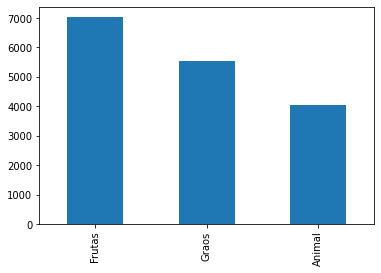

In [18]:
# Mostra balanceamento das classes (gráfico de barras )
sub.classe.value_counts().plot(kind='bar')

In [19]:
# Separa os dados de treino e teste (proporção 80/20, stratify para classes desbalanceadas)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sub.texto, sub.classe, test_size=0.2, 
                                                    stratify=sub.classe,random_state=42)

In [20]:
# Mostra um exemplo do texto.
X_train[0]

'centr orig pereira?'

In [21]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (13276,) 
 Frutas    0.423923
Graos     0.333308
Animal    0.242769
Name: classe, dtype: float64 

TESTE  :  (3320,) 
 Frutas    0.423795
Graos     0.333434
Animal    0.242771
Name: classe, dtype: float64


In [22]:
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_features=50000,ngram_range=(1,2))
# # tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# # mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

Vocabulário: 
{'volum': 49779, 'mundial': 28771, 'export': 17986, 'princip': 36525, 'pas': 32405, 'algodo': 1405, 'volum mundial': 49794, 'mundial export': 28782, 'export princip': 18016, 'princip pas': 36642, 'pas export': 32419, 'export algodo': 17987, 'qua': 38342, 'med': 26720, 'recomend': 40177, 'par': 31398, 'control': 10561, 'cercosporios': 7646, 'milho': 27635, 'qua princip': 38588, 'princip med': 36621, 'med recomend': 26754, 'recomend par': 40232, 'par control': 31588, 'control cercosporios': 10598, 'cercosporios milho': 7647, 'limit': 25021, 'mnim': 27931, 'pluvios': 34600, 'cultur': 12034, 'gergelim': 20938, 'pod': 34694, 'produzir': 37617, 'limit mnim': 25037, 'mnim pluvios': 27945, 'pluvios cultur': 34601, 'cultur gergelim': 12093, 'gergelim pod': 20989, 'pod produzir': 34851, 'constru': 10245, 'manjedoura': 26127, 'constru manjedoura': 10252, 'feit': 18819, 'extra': 18102, 'le': 24693, 'soja': 44237, 'feit extra': 18909, 'extra le': 18108, 'le soja': 24717, 'ocorr': 3019

In [23]:
# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
# mostra as dimensões da matrix tf-idf
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)


Dimensões da matrix: 
(13276, 50000)


## Treina o classificador

In [24]:
rf_class = RandomForestClassifier( random_state=42)
rf_class.fit(tfidf_vector, y_train)
rf_class.score(tfidf_vectorizer.transform(X_test), y_test)

0.8376506024096385

In [25]:
rl_class = LogisticRegression(max_iter=3000)
rl_class.fit(tfidf_vector, y_train)
rl_class.score(tfidf_vectorizer.transform(X_test), y_test)

0.8759036144578313

In [26]:
reg_log = SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-06)
reg_log.fit(tfidf_vector, y_train)
reg_log.score(tfidf_vectorizer.transform(X_test), y_test)

0.8939759036144578

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
eclf = VotingClassifier(
    estimators=[('rf_class', rf_class), ('rl_class', rl_class), ('reg_log', reg_log)],
    voting='hard', )

for clf, label in zip([rf_class, rl_class, reg_log, eclf], [ 'Random Forest', 'Logistic Regression','SGD', 'Ensemble']):
    scores = cross_val_score(clf, tfidf_vector, y_train, scoring='accuracy', cv=5)
    print(f"{label} : {scores.mean():0.3f} (+/- {scores.std():0.3f})")


Random Forest : 0.826 (+/- 0.004)
Logistic Regression : 0.854 (+/- 0.003)
SGD : 0.880 (+/- 0.001)
